# <font style="color:blue">DarkNet YOLO v3 Demo</font>
In this notebook, we will use darknet and perform inference on an image which contains the scene of a traffic. We will build the darknet framework and use YOLO v3 to perform object detection.

# <font style="color:blue">1. Change Runtime Type</font>
Before proceeding, make sure that the notebook is running on the GPU. Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

# <font style="color:blue">2. Clone the DarkNet Repository </font>
The official DarkNet repo is https://github.com/pjreddie/darknet. But unfortunately that repo is not maintained anymore (The last commit was in Sep, 2018). So, we will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [1]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 13621, done.
remote: Total 13621 (delta 0), reused 0 (delta 0), pack-reused 13621
Receiving objects: 100% (13621/13621), 12.24 MiB | 24.05 MiB/s, done.
Resolving deltas: 100% (9292/9292), done.


# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [2]:
%cd darknet

!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2 minutes")

!make &> build_log.txt

print("Build completed.")

/content/darknet
Building. . . It might take 2 minutes
Build completed.


# <font style="color:blue">4. Download YOLO v3 weights</font>
We will download the weights file. We will download the file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [3]:
# We will use the model weights from our repo ( Author's link https://pjreddie.com/media/files/yolov3.weights is slow to download )

!wget "https://www.dropbox.com/s/bdafgfb7qzcwh1o/yolov3.weights?dl=1" -O yolov3.weights

--2020-06-04 12:46:17--  https://www.dropbox.com/s/bdafgfb7qzcwh1o/yolov3.weights?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/bdafgfb7qzcwh1o/yolov3.weights [following]
--2020-06-04 12:46:17--  https://www.dropbox.com/s/dl/bdafgfb7qzcwh1o/yolov3.weights
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c056325659edcb2adcf717fae.dl.dropboxusercontent.com/cd/0/get/A5BEixui3ibWQzQcCc08pRHSh1yFR2uevQcIJV1RRuE3U2wiA2fYxJ-kirwGhmtEd47wJ661ccb-rk59H9UWYzKcUBIgLUqaW0xa4-jY--KeODDspi5328QmAZEeoCzL1-M/file?dl=1# [following]
--2020-06-04 12:46:17--  https://uc1c056325659edcb2adcf717fae.dl.dropboxusercontent.com/cd/0/get/A5BEixui3ibWQzQcCc08pRHSh1yFR2uevQcIJV1RRuE3U2wiA2fYxJ-kirwGhmtEd47wJ661ccb-rk59H9UWYzKcUBIgLUqaW0xa4-jY--

# <font style="color:blue">5. Download a Test Image</font>
We will download the test image which is an image of a traffic scene. Note that there is an ambulance on the bottom left.

In [4]:
!wget "https://www.dropbox.com/s/aad0pw7pf4ygs4b/traffic_1.jpg?dl=1" -O traffic.jpg

--2020-06-04 12:46:31--  https://www.dropbox.com/s/aad0pw7pf4ygs4b/traffic_1.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/aad0pw7pf4ygs4b/traffic_1.jpg [following]
--2020-06-04 12:46:32--  https://www.dropbox.com/s/dl/aad0pw7pf4ygs4b/traffic_1.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf1ef2f44006225a9967b779aa4.dl.dropboxusercontent.com/cd/0/get/A5DMKDndKPpZWGpB_Eg_KNPI_oiGHCsdp-xtzT2FFNbPXomSZJzaU6ysX9xjZPZJjE-p5xcLdyuf2ab80rOfDlO5RLyO0WWOp6PRGuZzwQ6YIbt_z2FdDoXpLQDoVQjkMrQ/file?dl=1# [following]
--2020-06-04 12:46:32--  https://ucf1ef2f44006225a9967b779aa4.dl.dropboxusercontent.com/cd/0/get/A5DMKDndKPpZWGpB_Eg_KNPI_oiGHCsdp-xtzT2FFNbPXomSZJzaU6ysX9xjZPZJjE-p5xcLdyuf2ab80rOfDlO5RLyO0WWOp6PRGuZzwQ6YI

![](https://www.dropbox.com/s/aad0pw7pf4ygs4b/traffic_1.jpg?dl=1)

# <font style="color:blue">6. Perform Inference</font>
Since we have build darknet, we will be able to perform inference using the executable using the following command. The command takes in a few arguments as explained below:
1. The first argument is the configuration file which defines the model.
1. The second argument is the weights file which we downloaded in the previous step
1. The third argument is the image path
1. The fourth argument is the confidence threshold below which the detections will be discarded.

The bounding boxes are overlayed on the image and saved in a file named **predictions.jpg**.

In [5]:
!./darknet detect cfg/yolov3.cfg yolov3.weights traffic.jpg -thresh 0.5

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

# <font style="color:blue">7. Display the output</font>
We will load opencv and matplotlib to display the output alongside the input image.

In [0]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

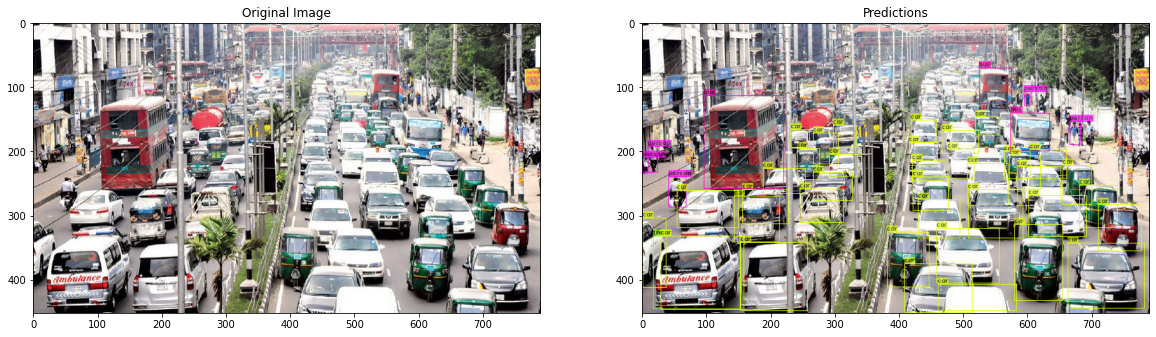

In [7]:
src = cv2.imread("traffic.jpg",1)
output = cv2.imread("predictions.jpg")

plt.figure(figsize=[20,8])
plt.subplot(121)
plt.imshow(src[:,:,::-1])
plt.title("Original Image")
plt.subplot(122)
plt.imshow(output[:,:,::-1])
plt.title("Predictions")
plt.show()

# <font style="color:blue">8. Conclusion</font>
We can see that the model was able to predict objects like Car, Truck, Person and Bus. But since it is not trained on objects like 3-wheeler etc, it is classifying them as a Car. It even identifies the ambulance as both Car and Truck.

We will train a model which identifies an Ambulance in the next section.